# Multi-instrument Data Analysis Workflows with the SunPy Ecosystem

## Notes

- AIA
- EUI
- SPICE
- DKIST

Bonus:
- IRIS (?)
- EIS (?)
- SOT/SP (?)

The affiliated packages we will use are:

- `sunpy`
- `sunpy-soar`
- `dkist`
- `sunraster`

The interesting science question we will answer is...

- Observations from chromosphere (dkist) to TR (SPICE) to corona (AIA, EUI)
- How can additional FOV constraints tell us more about what DKIST is seeing?

Rough plan

- Overlay fields of view of different instruments on AIA full-disk context image
- Locate an interesting feature in the HRI FOV--it is high resolution and shows a close-up view of the AR
- Locate points of common interest in the EUI and AIA fields of view
- Locate those points in the SPICE raster and extract a spectra, maybe fit
- Locate those points in the DKIST/VISP raster and extract a spectra, maybe fit
- Some kind of summary of these results at the end...

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sunpy.net import Fido, attrs as attrs
import astropy.units as u
from astropy.visualization import ImageNormalize, AsinhStretch
import sunpy.map
import sunraster.instr.spice

from sunpy.coordinates import get_earth, get_horizons_coord

## Searching for and Downloading Data with `Fido`

INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


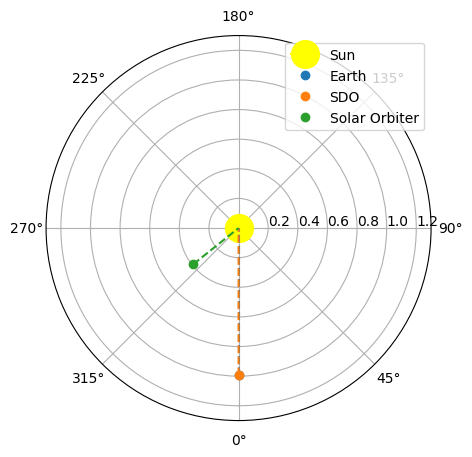

In [5]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(projection='polar')

# Plot the Sun
ax.plot(0, 0, marker='o', markersize=20, label='Sun', color='yellow')

# Plot the satellite locations
obstime = "2022-10-24 19:00"
for body_name in ['Earth', 'SDO', 'Solar Orbiter']:
    if body_name == 'Earth':
        body = get_earth(obstime)
    else:
        body = get_horizons_coord(body_name, time=obstime)
    p, = ax.plot(body.lon.to('rad'), body.radius.to(u.AU), 'o', label=body_name)
    ax.plot([body.lon.to_value('rad'), 0], [body.radius.to_value(u.AU), 0], ls='--', color=p.get_color())

ax.set_theta_zero_location("S")
ax.set_rlabel_position(90)
ax.set_rlim(0, 1.3)
ax.legend()

### SDO/AIA

In [6]:
time_range = attrs.Time("2022-10-24T18:55", "2022-10-24T19:35")

In [7]:
Fido.search(
    time_range,
    attrs.Instrument.aia,
    attrs.Wavelength(171*u.Angstrom),
    attrs.Sample(10*u.minute)
)

Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size
,,,,Angstrom,,,,,,,Mibyte
Time,Time,str3,str3,float64[2],str4,str9,str6,str4,str4,str8,float64
2022-10-24 18:55:09.000,2022-10-24 18:55:10.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2022-10-24 19:05:09.000,2022-10-24 19:05:10.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2022-10-24 19:15:09.000,2022-10-24 19:15:10.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2022-10-24 19:25:09.000,2022-10-24 19:25:10.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844


### Solar Orbiter--EUI and SPICE

In [8]:
import sunpy_soar

In [9]:
Fido.search(
    time_range,
    attrs.soar.Product('EUI-HRIEUV174-IMAGE') | attrs.soar.Product('EUI-FSI174-IMAGE') | attrs.soar.Product('SPICE-N-RAS'),
    attrs.Level(2)
)

Instrument,Data product,Level,Start time,End time,Data item ID,Filename,Filesize,SOOP Name
,,,,,,,Mbyte,
str3,str19,str2,str23,str23,str46,str55,float64,str30
EUI,EUI-HRIEUV174-IMAGE,L2,2022-10-24 19:29:55.174,2022-10-24 19:29:56.824,solo_L2_eui-hrieuv174-image_20221024T192955174,solo_L2_eui-hrieuv174-image_20221024T192955174_V01.fits,5.665,R_SMALL_MRES_MCAD_AR-Long-Term
EUI,EUI-HRIEUV174-IMAGE,L2,2022-10-24 19:29:30.174,2022-10-24 19:29:31.824,solo_L2_eui-hrieuv174-image_20221024T192930174,solo_L2_eui-hrieuv174-image_20221024T192930174_V01.fits,5.679,R_SMALL_MRES_MCAD_AR-Long-Term
EUI,EUI-HRIEUV174-IMAGE,L2,2022-10-24 19:29:10.174,2022-10-24 19:29:11.824,solo_L2_eui-hrieuv174-image_20221024T192910174,solo_L2_eui-hrieuv174-image_20221024T192910174_V01.fits,5.665,R_SMALL_MRES_MCAD_AR-Long-Term
EUI,EUI-HRIEUV174-IMAGE,L2,2022-10-24 19:20:25.173,2022-10-24 19:20:26.823,solo_L2_eui-hrieuv174-image_20221024T192025173,solo_L2_eui-hrieuv174-image_20221024T192025173_V01.fits,5.504,R_SMALL_MRES_MCAD_AR-Long-Term
EUI,EUI-HRIEUV174-IMAGE,L2,2022-10-24 19:28:40.174,2022-10-24 19:28:41.824,solo_L2_eui-hrieuv174-image_20221024T192840174,solo_L2_eui-hrieuv174-image_20221024T192840174_V01.fits,5.662,R_SMALL_MRES_MCAD_AR-Long-Term
EUI,EUI-HRIEUV174-IMAGE,L2,2022-10-24 19:28:20.204,2022-10-24 19:28:21.854,solo_L2_eui-hrieuv174-image_20221024T192820204,solo_L2_eui-hrieuv174-image_20221024T192820204_V01.fits,5.659,R_SMALL_MRES_MCAD_AR-Long-Term
EUI,EUI-HRIEUV174-IMAGE,L2,2022-10-24 19:27:55.188,2022-10-24 19:27:56.838,solo_L2_eui-hrieuv174-image_20221024T192755188,solo_L2_eui-hrieuv174-image_20221024T192755188_V01.fits,5.679,R_SMALL_MRES_MCAD_AR-Long-Term
EUI,EUI-HRIEUV174-IMAGE,L2,2022-10-24 19:27:35.189,2022-10-24 19:27:36.839,solo_L2_eui-hrieuv174-image_20221024T192735189,solo_L2_eui-hrieuv174-image_20221024T192735189_V01.fits,5.665,R_SMALL_MRES_MCAD_AR-Long-Term


### DKIST

In [10]:
import dkist.net

In [11]:
Fido.search(
    time_range,
    attrs.Instrument('VISP')
)

Start Time,End Time,Instrument,Wavelength,Bounding Box,Dataset ID,Dataset Size,Exposure Time,Primary Experiment ID,Primary Proposal ID,Stokes Parameters,Target Types,Number of Frames,Average Fried Parameter,Embargoed,Downloadable,Has Spectral Axis,Has Temporal Axis,Average Spectral Sampling,Average Spatial Sampling,Average Temporal Sampling
,,,nm,,,Gibyte,s,,,,,,,,,,,nm,arcsec,s
Time,Time,str4,float64[2],str32,str5,float64,float64,str9,str9,str4,str7[1],int64,float64,bool,bool,bool,bool,float64,float64,float64
2022-10-24T18:57:45.634,2022-10-24T19:33:26.865,VISP,630.2424776472172 .. 631.826964866207,"(233.36,-368.87),(212.1,-503.97)",BKEWK,5.0,48.00811267605634,eid_1_123,pid_1_123,IQUV,unknown,2752,0.11445240041497136,False,True,True,True,0.00162511509639976,0.04160701928854328,1070.6156795058157


### Combining them all...

In [12]:
aia_query = attrs.Instrument.aia & attrs.Wavelength(171*u.Angstrom) & attrs.Sample(10*u.minute)

In [13]:
solo_query = (attrs.soar.Product('EUI-HRIEUV174-IMAGE') | 
              attrs.soar.Product('EUI-FSI174-IMAGE') | 
              attrs.soar.Product('SPICE-N-RAS')) & attrs.Level(2)

In [14]:
dkist_query = attrs.Instrument('VISP')

In [15]:
q = Fido.search(time_range, aia_query | solo_query | dkist_query)

In [16]:
q

<sunpy.net.fido_factory.UnifiedResponse object at 0x17b9371d0>
Results from 5 Providers:

4 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 271.155 Mbyte

       Start Time               End Time        Source Instrument   Wavelength   Provider ... Wavetype Extent Width Extent Length Extent Type   Size  
                                                                     Angstrom             ...                                                  Mibyte 
----------------------- ----------------------- ------ ---------- -------------- -------- ... -------- ------------ ------------- ----------- --------
2022-10-24 18:55:09.000 2022-10-24 18:55:10.000    SDO        AIA 171.0 .. 171.0     JSOC ...   NARROW         4096          4096    FULLDISK 64.64844
2022-10-24 19:05:09.000 2022-10-24 19:05:10.000    SDO        AIA 171.0 .. 171.0     JSOC ...   NARROW         4096          4096    FULLDISK 64.64844
2022-10-24 19:15:09.000 2022-10-24 19:15:10.000    SDO        AIA 171.0 .. 171.0     JSOC ...   NARROW         4096          4096    FULLDISK 64.64844
2022-10-24 19:25:09.000 2022-10-24 19:25:10.000    SDO        AIA 171.0 .. 171.0     JSOC ...   NARROW         4096          4096    FULLDISK 64.64844

360 Results from the SOARClient:

Instrument     Data product    Level        Start time               End time        Filesize           SOOP Name           
                                                                                      Mbyte                                 
---------- ------------------- ----- ----------------------- ----------------------- -------- ------------------------------
       EUI EUI-HRIEUV174-IMAGE    L2 2022-10-24 19:29:55.174 2022-10-24 19:29:56.824    5.665 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 2022-10-24 19:29:30.174 2022-10-24 19:29:31.824    5.679 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 2022-10-24 19:29:10.174 2022-10-24 19:29:11.824    5.665 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 2022-10-24 19:20:25.173 2022-10-24 19:20:26.823    5.504 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 2022-10-24 19:28:40.174 2022-10-24 19:28:41.824    5.662 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 2022-10-24 19:28:20.204 2022-10-24 19:28:21.854    5.659 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 2022-10-24 19:27:55.188 2022-10-24 19:27:56.838    5.679 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 2022-10-24 19:27:35.189 2022-10-24 19:27:36.839    5.665 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 2022-10-24 19:27:10.174 2022-10-24 19:27:11.824    5.659 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 2022-10-24 19:26:45.174 2022-10-24 19:26:46.824    5.659 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 2022-10-24 19:26:15.173 2022-10-24 19:26:16.823    5.628 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 2022-10-24 19:25:55.174 2022-10-24 19:25:56.824    5.662 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 2022-10-24 19:25:35.173 2022-10-24 19:25:36.823    5.662 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 2022-10-24 19:25:10.173 2022-10-24 19:25:11.823    5.662 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 2022-10-24 19:20:00.173 2022-10-24 19:20:01.823    5.547 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 2022-10-24 19:24:45.173 2022-10-24 19:24:46.823    5.639 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 2022-10-24 19:24:20.173 2022-10-24 19:24:21.823    5.662 R_SMALL_MRES_MCAD_AR-Long-Term
       ...                 ...   ...                     ...                     ...      ...                            ...
       EUI EUI-HRIEUV174-IMAGE    L2 2022-10-24 19:28:25.173 2022-10-24 19:28:2

In [24]:
files = Fido.fetch(q, path='data/{instrument}')

Files Downloaded:   0%|          | 0/372 [00:00<?, ?file/s]

solo_L2_eui-fsi174-image_20221024T192050179_V01.fits:   0%|          | 0.00/4.55M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20221024T191050177_V01.fits:   0%|          | 0.00/4.51M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20221024T190050195_V01.fits:   0%|          | 0.00/4.54M [00:00<?, ?B/s]

solo_L2_eui-fsi174-image_20221024T193050174_V01.fits:   0%|          | 0.00/4.39M [00:00<?, ?B/s]

## Visualizing Fields of View

In [17]:
m_aia = sunpy.map.Map('data/AIA/aia_lev1_171a_2022_10_24t19_15_09_35z_image_lev1.fits')

In [18]:
m_hri = sunpy.map.Map('data/EUI/solo_L2_eui-hrieuv174-image_20221024T191510172_V01.fits')

In [19]:
m_fsi = sunpy.map.Map('data/EUI/solo_L2_eui-fsi174-image_20221024T191050177_V01.fits')

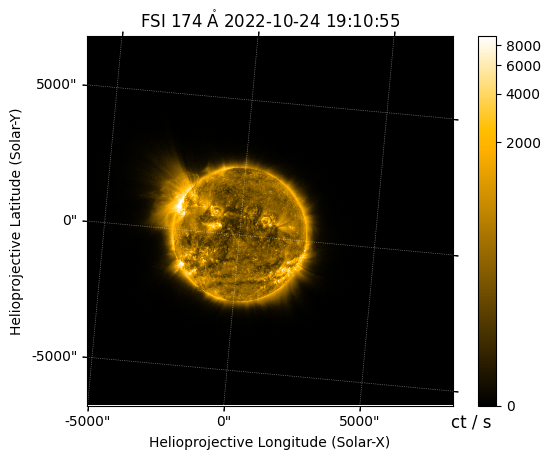

In [20]:
m_fsi.peek()

In [21]:
from astropy.coordinates import SkyCoord

In [22]:
m_fsi_zoom = m_fsi.submap(SkyCoord(-3000,-3000, unit='arcsec', frame=m_fsi.coordinate_frame),
                          top_right=SkyCoord(3000, 3000, unit='arcsec', frame=m_fsi.coordinate_frame))

In [23]:
from astropy.coordinates import SkyOffsetFrame

In [24]:
hri_rot_frame = SkyOffsetFrame(origin=m_hri.reference_coordinate,
                               rotation=-m_hri.meta['crota']*u.deg,
                               observer=m_hri.observer_coordinate)

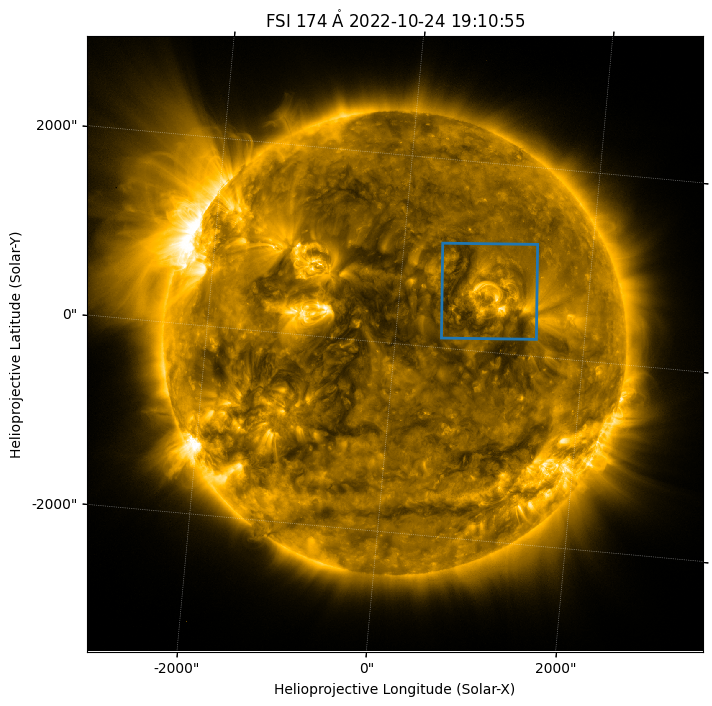

In [26]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=m_fsi_zoom)
m_fsi_zoom.plot(axes=ax)
m_fsi_zoom.draw_quadrangle(
    m_hri.bottom_left_coord.transform_to(hri_rot_frame),
    top_right=m_hri.top_right_coord.transform_to(hri_rot_frame),
    label='HRI',
    edgecolor='C0',
    lw=2
)

In [27]:
raster_spice = sunraster.instr.spice.read_spice_l2_fits('data/SPICE/solo_L2_spice-n-ras_20221024T191303_V04_150995395-059.fits')

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-OBS to 59876.800736 from DATE-OBS.
Set MJD-BEG to 59876.800736 from DATE-BEG.
Set MJD-AVG to 59876.804662 from DATE-AVG.
Set MJD-END to 59876.808585 from DATE-END'. [astropy.wcs.wcs]


In [185]:
spice_o6_window = raster_spice['O VI 1032 (Merged)'].apply_exposure_time_correction()  #[0,15,:,:]

In [186]:
m_spice_o6 = sunpy.map.Map(spice_o6_window[0,15,:,:].data, spice_o6_window[0,15,:,:].meta)

In [187]:
spice_rot_frame = SkyOffsetFrame(origin=m_spice_o6.reference_coordinate,
                                 rotation=-m_spice_o6.meta['crota']*u.deg,
                                 observer=m_spice_o6.observer_coordinate)

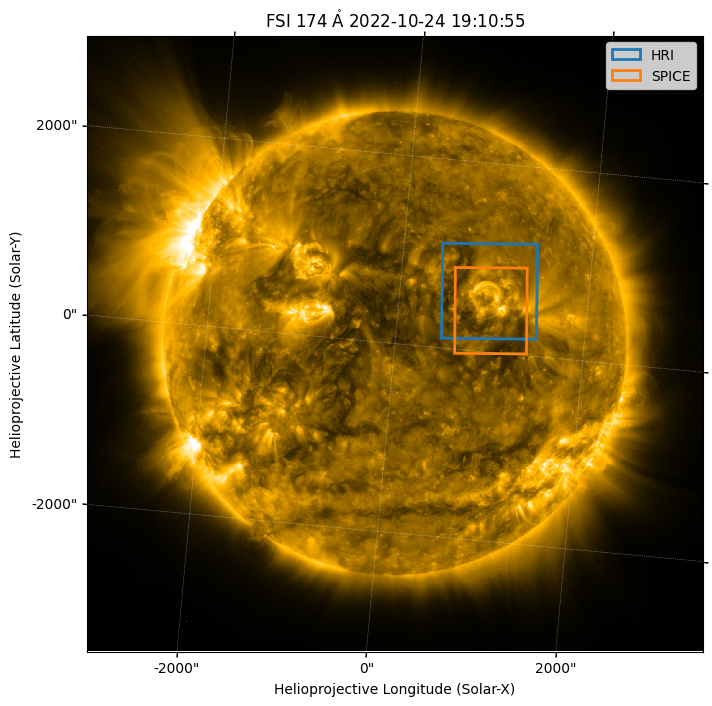

In [188]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=m_fsi_zoom)
m_fsi_zoom.plot(axes=ax)
m_fsi_zoom.draw_quadrangle(
    m_hri.bottom_left_coord.transform_to(hri_rot_frame),
    top_right=m_hri.top_right_coord.transform_to(hri_rot_frame),
    label='HRI',
    edgecolor='C0',
    lw=2
)
m_fsi_zoom.draw_quadrangle(
    m_spice_o6.bottom_left_coord.transform_to(spice_rot_frame),
    top_right=m_spice_o6.top_right_coord.transform_to(spice_rot_frame),
    label='SPICE',
    edgecolor='C1',
    lw=2
)
ax.legend()

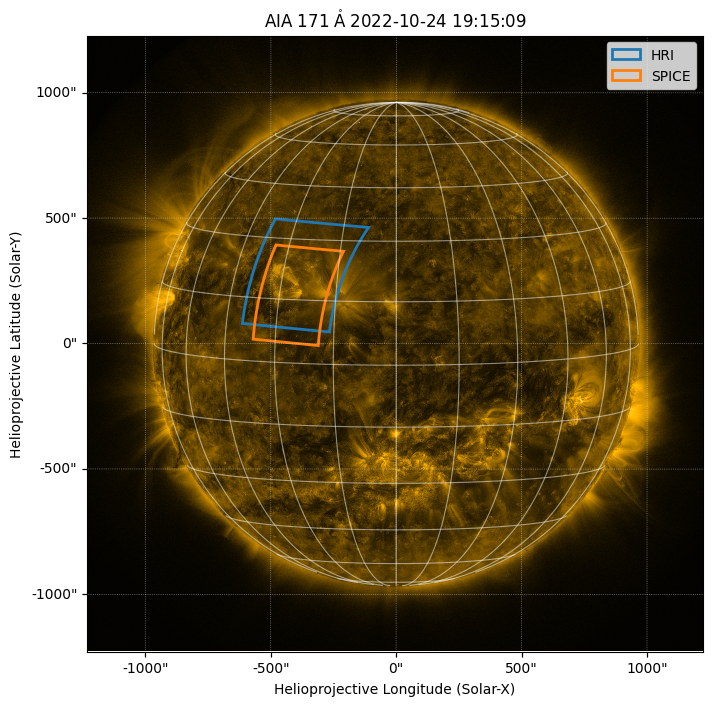

In [189]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=m_aia)
m_aia.plot(axes=ax)
m_aia.draw_quadrangle(
    m_hri.bottom_left_coord,
    top_right=m_hri.top_right_coord.transform_to(hri_rot_frame),
    label='HRI',
    edgecolor='C0',
    lw=2
)
m_aia.draw_quadrangle(
    m_spice_o6.bottom_left_coord,
    top_right=m_spice_o6.top_right_coord.transform_to(spice_rot_frame),
    label='SPICE',
    edgecolor='C1',
    lw=2
)
m_aia.draw_grid(axes=ax)
ax.legend()

## Reading in Cutouts

In [190]:
center = SkyCoord(Tx=930*u.arcsec, Ty=630*u.arcsec, frame=m_hri.coordinate_frame)
width = 350*u.arcsec
height = 250*u.arcsec
loop_fov = center.spherical_offsets_by(width/[-2, 2], height/[-2, 2])

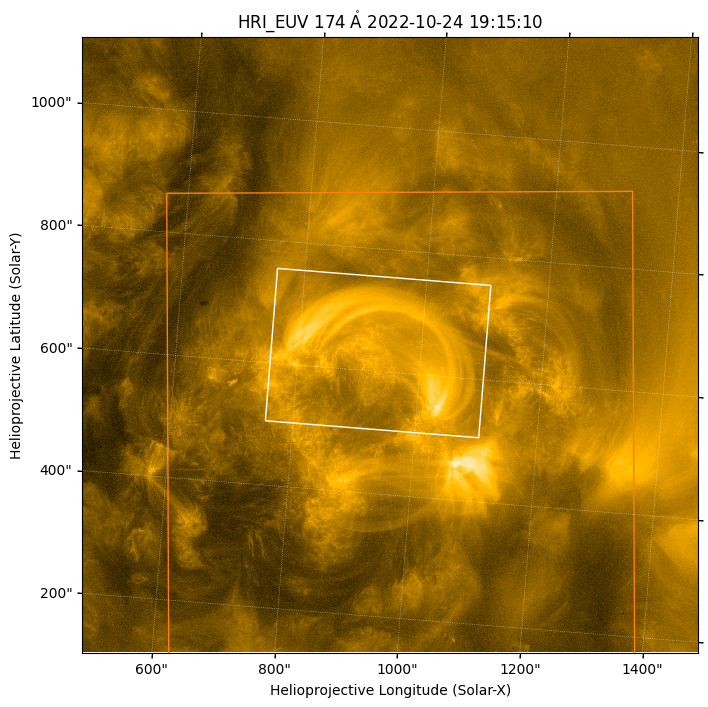

In [191]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=m_hri)
m_hri.plot(axes=ax)
m_hri.draw_quadrangle(loop_fov[0], top_right=loop_fov[1])
m_hri.draw_quadrangle(
    m_spice_o6.bottom_left_coord.transform_to(spice_rot_frame),
    top_right=m_spice_o6.top_right_coord.transform_to(spice_rot_frame),
    label='SPICE FOV',
    edgecolor='C1')

In [174]:
import pathlib
import warnings

import astropy.io.fits
import astropy.wcs
from astropy.nddata import Cutout2D

from sunpy.coordinates import propagate_with_solar_surface

In [175]:
hri_maps = []
for filename in sorted(pathlib.Path('./data/EUI/').glob('solo_L2_eui-hrieuv174-image_*.fits')):
    with astropy.io.fits.open(filename) as hdul:
        with warnings.catch_warnings():  # silence some astropy FITS warnings
            warnings.simplefilter('ignore', astropy.wcs.FITSFixedWarning)
            wcs = astropy.wcs.WCS(hdul[1].header)
        with propagate_with_solar_surface():  # transform with solar rotation
            cutout = Cutout2D(hdul[1].section,  # cutout from full-image
                              position=center,
                              size=(height, width),
                              wcs=wcs)
    hri_maps.append(sunpy.map.Map(cutout.data, cutout.wcs))  # create sunpy map

In [176]:
hri_maps = sunpy.map.Map(hri_maps, sequence=True)

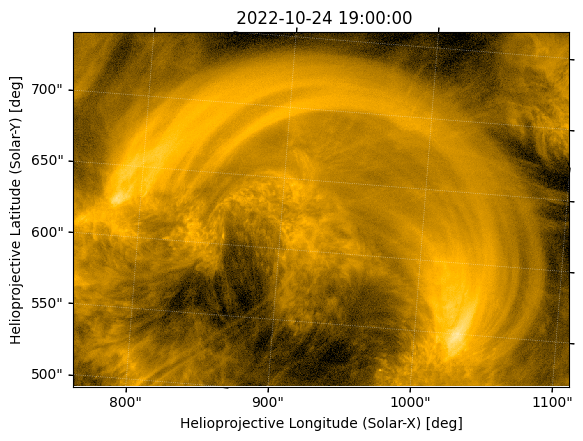

In [181]:
ani = hri_maps.plot(cmap=m_hri.plot_settings['cmap'],
                    norm=ImageNormalize(vmin=5e2, vmax=1.75e4,
                                        stretch=m_hri.plot_settings['norm'].stretch))

In [183]:
# NOTE: need a better way to visualize this...I'm not sure what the best strategy is here???
# I've had trouble playing the movie within the notebook interactively
ani.save('eui-hri-loops.mp4', fps=15, dpi=300)

In [120]:
# CUT
# this is neat, but is not fast, maybe not good for a live demo
# also what is the point???
wcs_middle = hri_maps[len(hri_maps)//2].wcs
with propagate_with_solar_surface():
    hri_maps_reprojected = [m.reproject_to(wcs_middle, algorithm='adaptive', roundtrip_coords=False) for m in hri_maps]
hri_maps_repr_seq = sunpy.map.Map(hri_maps_reprojected, sequence=True)

## Feature Identification

Can we make a time-distance plot in emission and a wavelength-distance plot in spectra?

In [223]:
# Could we do this identification with OCCULT2 in sunkit-image?
traced_loop =  SkyCoord(
    Tx=[786, 809, 853, 895, 955, 998, 1030, 1050, 1053, 1041, 1029]*u.arcsec,
    Ty=[623, 662, 703, 716, 720, 697, 664, 628, 594, 567, 541]*u.arcsec,
    frame=hri_maps[0].coordinate_frame,
)

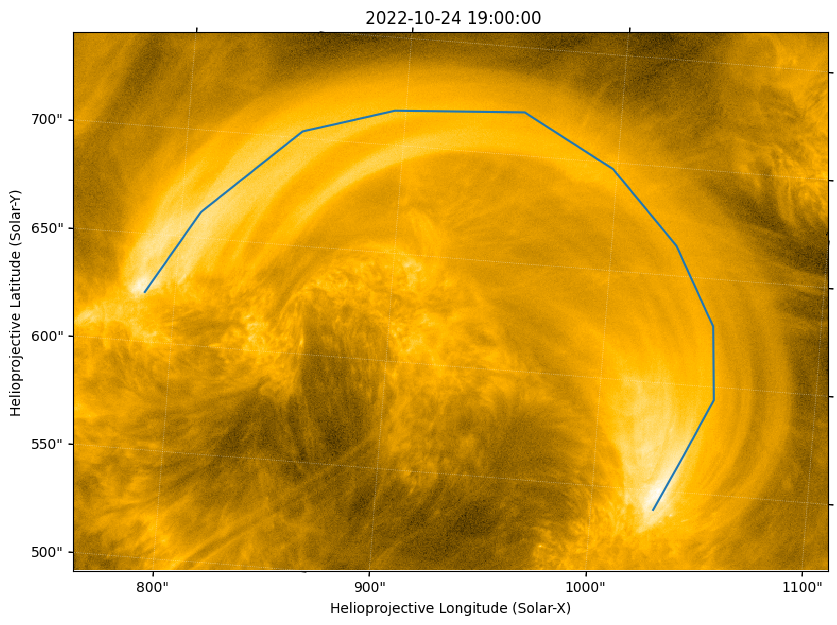

In [301]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(projection=hri_maps[0].wcs)
hri_maps[0].plot(axes=ax, **m_hri.plot_settings)
ax.plot_coord(traced_loop)

In [248]:
traced_loop_pixelated = sunpy.map.pixelate_coord_path(hri_maps[0], traced_loop)
intensity = sunpy.map.sample_at_coords(hri_maps[0], traced_loop_pixelated)

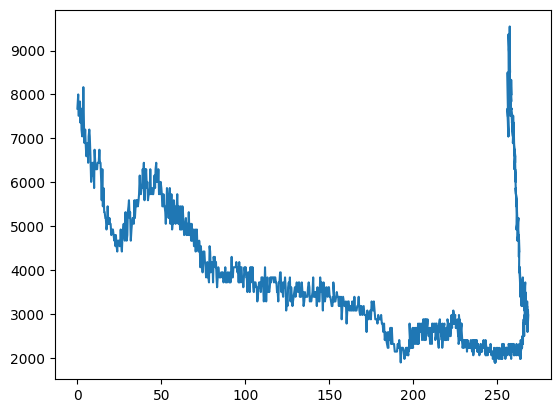

In [249]:
plt.plot(np.sqrt((traced_loop_pixelated.Tx - traced_loop_pixelated.Tx[0])**2 + (traced_loop_pixelated.Ty-traced_loop_pixelated.Ty[0])**2), intensity)

Now, question is, what does this look like in the SPICE data?

In [141]:
plate_scale = spice_o6_window.wcs.wcs.cdelt[:2]
aspect_ratio = plate_scale[1]/plate_scale[0]

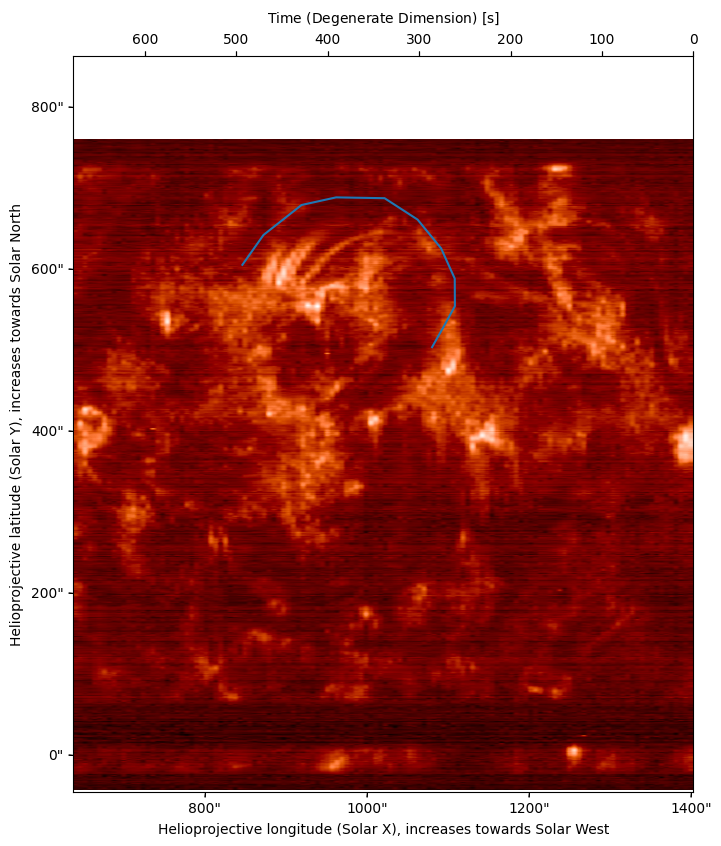

In [300]:
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(projection=spice_o6_window[0,15,:,:].wcs)
spice_o6_window[0,15,:,:].plot(axes=ax,
                               aspect=aspect_ratio,
                               cmap='irissjiFUV',
                               norm=ImageNormalize(stretch=AsinhStretch()))
# FIXME: how does this work when the WCS does not just represent lat/lon? Does it?
#with propagate_with_solar_surface():
#    _ = traced_loop.transform_to(m_spice_o6.coordinate_frame)
#ax.plot_coord(_)
with propagate_with_solar_surface():
    pix = spice_o6_window[0,15,:,:].wcs.world_to_pixel(traced_loop, traced_loop.obstime)
ax.plot(*pix)

<WCSAxes: ylabel='Data [adu / s]'>

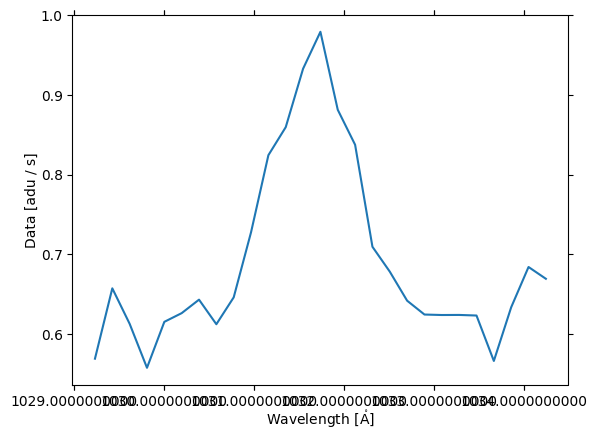

In [298]:
spice_o6_window[0,:,400,75].plot(axes_units=['Angstrom'])

Let's visualize the SPICE slit position across the HRI FOV

In [165]:
spice_o6_window[0,:,:,:]

SpectrogramCube
---------------
Time Period: ['2022-10-24 19:13:06.119' '2022-10-24 19:24:19.219']
Instrument axes: ['spectral' 'slit' 'slit step']
Pixel dimensions: [ 31 830 128] pix
Longitude range: [ 564.52300363 1400.09978535] arcsec
Latitude range: [-44.03835848 926.83660158] arcsec
Spectral range: [1.02885259e-07 1.03462639e-07] m
Data unit: adu

### Observations from VISP

- Load the calibrated DKIST data
- Identify needed feature. 
- Extract spectra
- ...profit?

## Bringing it all together

I'm not sure how to best summarize all of this together...reprojection? 